In [1]:
# Load config
from config import UNetTraining
# from config import UNetTraining
config = UNetTraining.Configuration()

In [2]:
from config import colors
colors = colors.bcolors()

# 0. Imports

In [57]:
import tensorflow as tf

import numpy as np
import rasterio
# from rasterio.windows import Window

# import imgaug as ia
# from imgaug import augmenters as iaa
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import time
import rasterio.warp # Reproject raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta #, adagrad, adam, nadam
# from core.frame_info import FrameInfo
# from core.dataset_generator import DataGenerator
# from core.split_frames import split_dataset
# from core.visualize import display_images

import json
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
from sys import platform

if platform == "linux" or platform == "linux2":
    path_satellite = "/home/jovyan/work/satellite_data/"
    path_labels = os.getcwd() + "/1_labeled_data/tif/"
    cutouts_path = os.getcwd() + "/2_cutouts/"
elif platform == "darwin":
    path_data = "/Users/leori/Desktop/BA/1_Data/"
    path_satellite = path_data + "2_satellite/"
    path_labels = path_data + "1_labeled_data/tif/"
    cutouts_path = None
elif platform == "win32":
    print("Something went wrong")

# 1. Training

### Get Label Area with Export

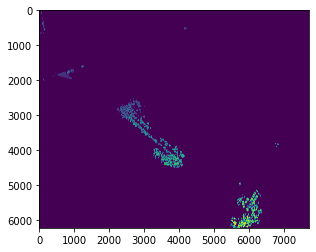

<AxesSubplot:>

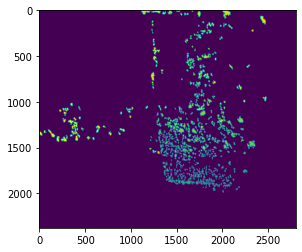

<AxesSubplot:>

In [5]:
from rasterio.plot import show
src_label_nw = rasterio.open(config.filepath_label_nw)
src_label_se = rasterio.open(config.filepath_label_se)
src_label_read_nw = src_label_nw.read()
src_label_read_se = src_label_se.read()
show(src_label_read_nw)
show(src_label_read_se)

In [6]:
filepath_labeled_areas = [config.filepath_label_nw, config.filepath_label_se]

### Patchify

#### Create Label Area Patches

In [8]:
label_area_1 = rasterio.open(filepath_labeled_areas[0])
label_area_2 = rasterio.open(filepath_labeled_areas[1])
opened_label_areas = [label_area_1, label_area_2]

In [9]:
total_patches = 0
for label_area in opened_label_areas:
    label_area.width, label_area.height
    patches = round(label_area.width/224) * round(label_area.height/224)
    total_patches += patches
    print(total_patches)

(7727, 6223)

952


(2802, 2377)

1095


In [10]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify

satellite_img = rasterio.open(config.filepath_satellite)
label_img = rasterio.open(config.filepath_label)

In [36]:
%%time
# label_area. In other projects may be referred to as mask
patches_labels = []
for label_area in opened_label_areas:
    patches_labels = patchify(label_area.read(1), 
        (config.patch_size[0], config.patch_size[1]), 
        step=config.patch_size[0]-config.overlap)
    # TODO: could also export patches to files like this:
    # for i in range(patches_labels.shape[0]):
    #     for j in range(patches_labels.shape[1]):
    #         single_patch = patches_labels[i, j,:,:]
    #         filename = opened_label_areas[0].name.replace(config.path_labeled_data_areas,"")[:-4] # -4 to cut off the .tif file extension
    #         filepath_single_patch = "{}-{}-patch-{}-{}.tif".format(config.path_patches_masks, filename, i, j)
    #         # gdal.Translate(filepath_single_patch, single_patch, projWin = )
    #         # single_patch.write(filepath_single_patch)
print("Mask/Label Patch Shape:", patches_labels.shape)

Mask/Label Patch Shape: (10, 12, 256, 256)
CPU times: user 113 ms, sys: 368 ms, total: 481 ms
Wall time: 615 ms


In [37]:
patches_labels.shape

(10, 12, 256, 256)

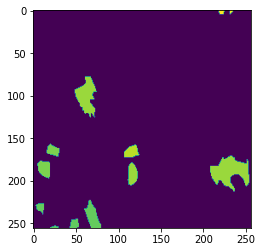

<AxesSubplot:>

In [38]:
# visualize single patch
# show(patches_labels[17][16])
show(patches_labels[7][9])

#### Create Satellite Area Patches

In [39]:
%%time
from rasterio.windows import from_bounds
patches_satellite = []
for index, label_area in enumerate(opened_label_areas):
    # get coordinates
    cur_coords = (west, south, east, north) = opened_label_areas[index].bounds
    print(cur_coords)
    
    satellite_area = satellite_img.read([1,2,3], window = from_bounds(west, south, east, north, satellite_img.transform))
    
    cropped_window = (west,north,east,south)
    filename = opened_label_areas[0].name.replace(config.path_labeled_data_areas,"")[6:-4] # -4 to cut off the .tif file extension and 6 to cut off label
    filepath_satellite_area = "{}areas/{}.tif".format(config.path_patches_satellite, filename)

    patches_satellite = patchify(satellite_area, 
        (3, config.patch_size[0], config.patch_size[1]), 
        step=config.patch_size[0]-config.overlap)[0]
    
    # or reshape now:
    # satellite_area_reshaped = np.reshape(satellite_area, (satellite_area.shape[1],satellite_area.shape[2],3))
    # patches_satellite = patchify(satellite_area_reshaped, 
    #     (config.patch_size[0], config.patch_size[1], 3), 
    #     step=config.patch_size[0]-config.overlap)[0]

    # TODO: SAVE TO SEPARATE IMG + LOAD IT
    # gdal.Translate(filepath_satellite_area, satellite_area, projWin = cropped_window)
    # could also export patches to files like this:
    # for i in range(patches_satellite.shape[0]):
    #     for j in range(patches_satellite.shape[1]):
    #         single_patch = patches_satellite[i, j,:,:]
    #         filename = opened_label_areas[0].name.replace(config.path_labeled_data_areas,"")[:-4] # -4 to cut off the .tif file extension
    #         filepath_single_patch = "{}-{}-patch-{}-{}.tif".format(config.path_patches_masks, filename, i, j)
    #         # gdal.Translate(filepath_single_patch, single_patch, projWin = )
    #         # single_patch.write(filepath_single_patch)
print("Satellite Patch Shape:", patches_satellite.shape)

BoundingBox(left=29.748165907, bottom=-26.263430008, right=29.766500302, top=-26.248664052)
BoundingBox(left=29.995271839179495, bottom=-26.501297921923136, right=30.001920300509017, top=-26.495656803219298)
Satellite Patch Shape: (10, 12, 3, 256, 256)
CPU times: user 2.18 s, sys: 828 ms, total: 3.01 s
Wall time: 3.07 s


In [40]:
label_area.read(1).shape
satellite_area.shape

(2377, 2802)

(3, 2377, 2801)

In [41]:
satellite_area_reshaped = np.reshape(satellite_area, (satellite_area.shape[1],satellite_area.shape[2],3))
satellite_area_reshaped.shape

(2377, 2801, 3)

In [42]:
patches_labels.shape
patches_satellite.shape

(10, 12, 256, 256)

(10, 12, 3, 256, 256)

### Data Augmentation (still to do)

In [77]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomZoom(
  height_factor=(-0.05, -0.15),
  width_factor=(-0.05, -0.15)
  ),
  # tf.keras.layers.experimental.preprocessing.RandomRotation(0.9) # optional rotation
])

In [ ]:
# Add the image to a batch
satellite_area_reshaped = tf.cast(tf.expand_dims(satellite_area_reshaped, 0), tf.uint8) # satellite_area_reshaped.dtype => dtype('uint8')

In [ ]:
# Incorporation into tf.data pipeline:
trainDS = tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train))
trainDS = (
	trainDS
	.shuffle(config.BATCH_SIZE * 100)
	.batch(config.BATCH_SIZE)
	.map(lambda x, y: (data_augmentation(x), y),
		 num_parallel_calls=tf.data.AUTOTUNE)
	.prefetch(tf.data.AUTOTUNE)
)

### Data Preparation for Training

#### Reshape Patches to Fit to the Model

In [44]:
patches_satellite.shape
patches_labels.shape

(10, 12, 3, 256, 256)

(10, 12, 256, 256)

In [45]:
shape = patches_satellite.shape
patches_satellite_reshaped = patches_satellite.reshape(shape[0]*shape[1], shape[2], shape[3], shape[4])
patches_satellite_reshaped.shape

(120, 3, 256, 256)

In [46]:
shape = patches_labels.shape
patches_labels_reshaped = patches_labels.reshape(shape[0]*shape[1], shape[2], shape[3])
patches_labels_reshaped.shape

(120, 256, 256)

#### Feature Scaling & Data Correction

In [47]:
# scale the color values
patches_satellite_training = np.where(True, patches_satellite_reshaped / 255, patches_satellite_reshaped)

In [48]:
# make all values of the array which are not 0, 1. Either label or no label. 
# This has to be performed, because the exported labels have color values, which have to be normalized. 
# Somehow, some color values have been above 255, which might have happened due to a faulty export from QGIS. 
patches_labels_training = np.where(patches_labels_reshaped != 0.0, 1.0, patches_labels_reshaped)
# conversion to the same type as patches_satellite_training ('float64')
patches_labels_training = patches_labels_training.astype(patches_satellite_training.dtype)

#### Create Training and Test Dataset

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches_satellite_training, patches_labels_training, test_size=config.test_ratio, random_state=42)

In [50]:
for i in [X_train, X_test, y_train, y_test]:
    i.shape

(96, 3, 256, 256)

(24, 3, 256, 256)

(96, 256, 256)

(24, 256, 256)

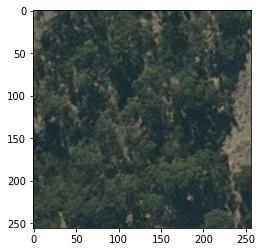

<AxesSubplot:>

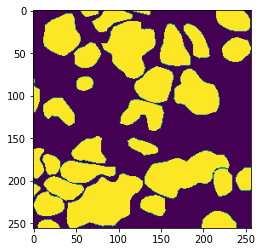

<AxesSubplot:>

In [ ]:
# sanity check: check if satellite and label data matches
x = 16
show(X_train[x])
show(y_train[x])

In [51]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3], X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3], X_test.shape[1])
# X_train, X_test, y_train, y_test

### Compile Model

In [43]:
OPTIMIZER = adaDelta
LOSS = tversky 

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'AdaDelta'
LOSS_NAME = 'weightmap_tversky'

# Declare the path to the final model
# If you want to retrain an exising model then change the cell where model is declared. 
# This path is for storing a model after training.

timestr = time.strftime("%Y%m%d-%H%M")
chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '')


if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
model_path = os.path.join(config.model_path,'trees_{}_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs,config.input_shape[0]))

# The weights without the model architecture can also be saved. Just saving the weights is more efficent.

# weight_path="./saved_weights/UNet/{}/".format(timestr)
# if not os.path.exists(weight_path):
#     os.makedirs(weight_path)
# weight_path=weight_path + "{}_weights.best.hdf5".format('UNet_model')
# print(weight_path)

In [ ]:
# Define the model and compile it
model = UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, specificity, sensitivity, accuracy])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        Input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

#reduceonplatea; It can be useful when using adam as optimizer
#Reduce learning rate when a metric has stopped improving (after some patience,reduce by a factor of 0.33, new_lr = lr * factor).
#cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=4, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16)

#early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=15)

log_dir = os.path.join('./logs','UNet_{}_{}_{}_{}_{}'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, config.input_shape[0]))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, tensorboard] #reduceLROnPlat is not required with adaDelta

### Training

- Maybe Model defined to only receive one input and not rgb => test out or look into model | but project has 2 color channels
- maybe data generator adjusts data? But does not affect model

In [ ]:
%%time
if 0:
        loss_history = [model.fit(x=X_train_reshaped,
                                y=y_train,
                                epochs=config.NB_EPOCHS, 
                                # validation_data=y_train,
                                steps_per_epoch=config.MAX_TRAIN_STEPS,
                                # validation_steps=config.VALID_IMG_COUNT,
                                batch_size=config.BATCH_SIZE,
                                callbacks=callbacks_list,
                                # workers=1,
                                # use_multiprocessing=True # the generator is not very thread safe
                        )]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [ ]:
model.evaluate(X_test_reshaped, y_test)

6/6 [==============================] - 133s 21s/step - loss: 0.5346 - dice_coef: 0.0226 - dice_loss: 0.9774 - specificity: 3.3091e-04 - sensitivity: nan - accuracy: 0.0117


[0.534647524356842,
 0.02258480340242386,
 0.977415144443512,
 0.0003309091553092003,
 nan,
 0.011714189313352108]

In [ ]:
#%%script false
#Plot accuracy and loss of train and val set
plt.rcParams.update({'font.family':'serif'})

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(loss_history.history['accuracy'], color="green")
plt.plot(loss_history.history['val_accuracy'], color="blue")
plt.title("Accuracy", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(122)
plt.plot(loss_history.history['loss'], color="red",)
plt.plot(loss_history.history['val_loss'], color="orange")
plt.title("Loss", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
print("accuracy: " + str(loss_history.history['accuracy'][-1]))
print("loss:     " + str(loss_history.history['loss'][-1]))

print("Validation")
print("accuracy: " + str(loss_history.history['val_accuracy'][-1]))
print("loss:     " + str(loss_history.history['val_loss'][-1]))